# Unsupervised learning

In [4]:
from brian2 import *

### add input

In [25]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(np.zeros(Ns), np.arange(Ns), 'ok', ms=10)
    plot(np.ones(Nt), np.arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
def plot_spikes(mon):
    figure(figsize=(12,3))
    scatter(mon.t/ms, mon.i, s=10)
    for t in range(0, run_time, 2*change_time):
        axvline(t, ls='--', c='C1')
        axvline(t + change_time, ls='--', c='C2')        
    
    show()

def plot_syn_layer(L, n):
    figure(figsize=(18,4))
    subplot(131)
    for k in range(n):
        plot(L.t/ms, L.w_syn[k])
    subplot(132)
    for k in range(n):
        plot(L.t/ms, L.apre[k])
    subplot(133)
    for k in range(n):
        plot(L.t/ms, L.apost[k])
    show()

In [88]:
input_patterns = array([[0., 1.], [1., 0.]])
n_patterns = input_patterns.shape[0]
# input_patterns = input_patterns.reshape((n_patterns, -1))

poisson_params = 200, 1.

# stimulus = TimedArray(np.tile([100., 0.], 5)*Hz, dt=100.*ms)
# P = PoissonGroup(1, rates='stimulus(t)')

poisson_rates = input_patterns * np.random.normal(poisson_params[0], poisson_params[1], size=input_patterns.shape)
poisson_rates

array([[  0.        , 198.92470469],
       [200.04925993,   0.        ]])

In [89]:
start_scope()
seed(1337)

# Parameters
N = 2
C = 281 * pF
gL = 30 * nS
taum = C / gL
EL = -70.6 * mV
VT = -50.4 * mV
DeltaT = 2 * mV
Vcut = VT + 5 * DeltaT
Tr = 5 * ms
I_tonic = 0.3 * .6 * nA

# Pick an electrophysiological behaviour
tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, EL - 3 * mV # Regular spiking (as in the paper)
#tauw,a,b,Vr=20*ms,4*nS,0.5*nA,VT+5*mV # Bursting
# tauw,a,b,Vr=144*ms,2*C/(144*ms), 0*nA, EL - 3 * mV # Fast spiking

# stoch = ' + 0*xi*0.2*nA*ms**.5'
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w)/C : volt (unless refractory)
dw/dt = (a*(vm - EL) - w)/tauw : amp
I : amp
"""

n_tile = 50
change_time = 200
stimulus = TimedArray(
    np.tile(poisson_rates, (n_tile, 1)) * Hz,
    dt=change_time * ms
)
inPG = PoissonGroup(input_patterns.shape[1], rates='stimulus(t, i)')

L1 = NeuronGroup(
    N, model=eqs, threshold='vm>Vcut',
    reset="vm=Vr; w+=b", 
    refractory='vm>=Vcut',
    method='euler'
)
L1.vm = 'EL + rand()*5*mV'
L1.I = I_tonic

taupre = taupost = 20*ms
w_syn_max = 10.
Apre = 0.05 * w_syn_max
Apost = -Apre*taupre/taupost*1.05
inL = Synapses(
    inPG, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post += w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0., w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
inL.connect()
inL.w_syn = '.2 * w_syn_max * rand() + .4 * w_syn_max * (1 - j) * i + .4 * w_syn_max * (1 - i) * j'
inL.delay = 0 * 2 * ms

ihL = Synapses(
    L1, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post -= w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0., w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
ihL.connect(condition='i!=j')
inL.w_syn = 'w_syn_max * rand()'
ihL.delay = 0 * 2 * ms

inPG_spikes = SpikeMonitor(inPG)
L1_trace = StateMonitor(L1, 'vm', record=True)
L1_spikes = SpikeMonitor(L1)
inL_trace = StateMonitor(inL, ['w_syn', 'apre', 'apost'], record=True)
ihL_trace = StateMonitor(ihL, ['w_syn', 'apre', 'apost'], record=True)

run_time = 4000
run(4000 * ms)

# print(inL.w_)
# print(ihL.w_)
# visualise_connectivity(ihL)

<spikemonitor_3.count_: array([48, 55], dtype=int32)>


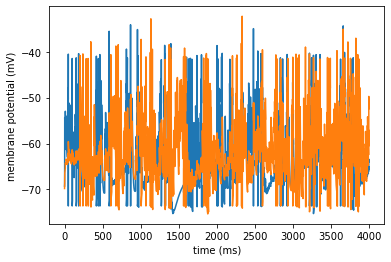

In [90]:
for k in range(2):
    plot(L1_trace.t / ms, L1_trace[k].vm / mV)
print(L1_spikes.count_)

xlabel('time (ms)')
ylabel('membrane potential (mV)')
show()

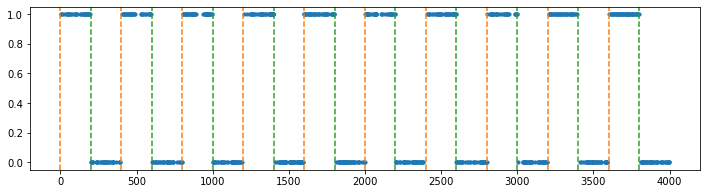

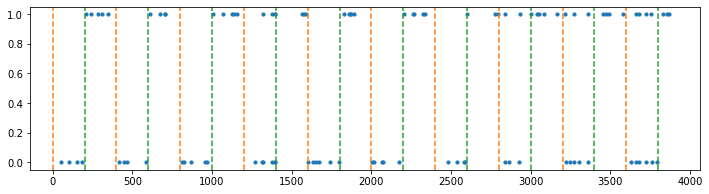

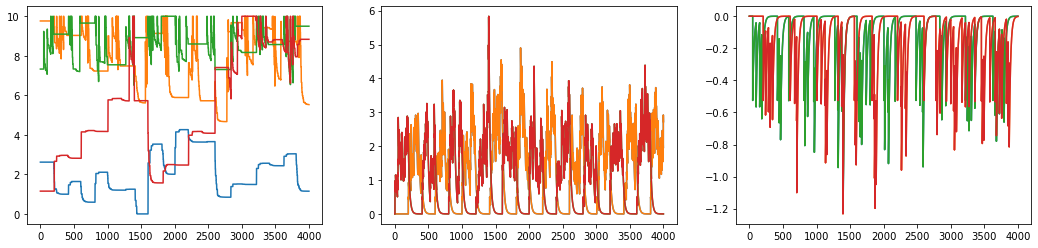

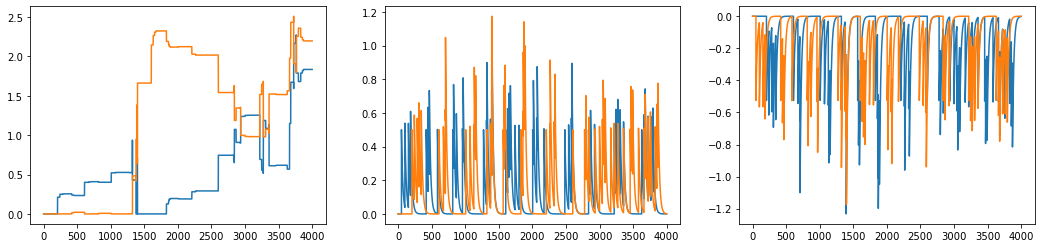

In [91]:
plot_spikes(inPG_spikes)
plot_spikes(L1_spikes)
plot_syn_layer(inL_trace, 4)
plot_syn_layer(ihL_trace, 2)

## Learning

In [334]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(np.zeros(Ns), np.arange(Ns), 'ok', ms=10)
    plot(np.ones(Nt), np.arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
def plot_spikes(mon):
    figure(figsize=(18,3))
    scatter(mon.t/ms, mon.i, s=10)
    for t in range(0, run_time, 2*change_time):
        axvline(t, ls='--', c='C1')
        axvline(t + change_time, ls='--', c='C2')        
    
    show()

def plot_syn_layer(L, n):
    figure(figsize=(18,4))
    subplot(131)
    for k in range(n):
        plot(L.t/ms, L.w_syn[k])
    subplot(132)
    for k in range(n):
        plot(L.t/ms, L.apre[k])
    subplot(133)
    for k in range(n):
        plot(L.t/ms, L.apost[k])
    show()

In [339]:
input_patterns = array([[0., 1.], [1., 0.]])
target_patterns = input_patterns
n_patterns = input_patterns.shape[0]
# input_patterns = input_patterns.reshape((n_patterns, -1))

poisson_params = 100, 1.

# stimulus = TimedArray(np.tile([100., 0.], 5)*Hz, dt=100.*ms)
# P = PoissonGroup(1, rates='stimulus(t)')

poisson_rates = input_patterns * np.random.normal(poisson_params[0], poisson_params[1], size=input_patterns.shape)
poisson_rates

target_rates = target_patterns * np.random.normal(poisson_params[0]/5, poisson_params[1], size=input_patterns.shape)
target_rates

array([[ 0.        , 19.09822447],
       [21.87781514,  0.        ]])

In [343]:
start_scope()
seed(1337)

# Parameters
N = 2
C = 281 * pF
gL = 30 * nS
taum = C / gL
EL = -70.6 * mV
VT = -50.4 * mV
DeltaT = 2 * mV
Vcut = VT + 5 * DeltaT
Tr = 5 * ms
I_tonic = 0.25 * .6 * nA

# Pick an electrophysiological behaviour
tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, EL - 3 * mV # Regular spiking (as in the paper)
#tauw,a,b,Vr=20*ms,4*nS,0.5*nA,VT+5*mV # Bursting
# tauw,a,b,Vr=144*ms,2*C/(144*ms), 0*nA, EL - 3 * mV # Fast spiking

# stoch = ' + 0*xi*0.2*nA*ms**.5'
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w + 0.05*xi*0.2*nA*ms**.5)/C : volt (unless refractory)
dw/dt = (a*(vm - EL) - w)/tauw : amp
I : amp
"""

n_tile = 40
change_time = 500
stimulus = TimedArray(
    np.tile(poisson_rates, (n_tile, 1)) * Hz,
    dt=change_time * ms
)
inPG = PoissonGroup(input_patterns.shape[1], rates='stimulus(t, i)')

target_stimulus = TimedArray(
    np.tile(target_rates, (n_tile, 1)) * Hz,
    dt=change_time * ms
)
tarPG = PoissonGroup(target_patterns.shape[1], rates='target_stimulus(t, i)')


L1 = NeuronGroup(
    N, model=eqs, threshold='vm>Vcut',
    reset="vm=Vr; w+=b", 
    refractory='vm>=Vcut',
    method='euler'
)
L1.vm = 'EL + rand()*5*mV'
L1.I = I_tonic

# Dopamine signaling
tauc = 400*ms
taud = 100*ms
taus = 5*ms
epsilon_dopa = .004
taupre = taupost = 50*ms
w_syn_max = 10.
Apre = 0.01 * w_syn_max
Apost = -Apre*taupre/taupost*1.05
inL = Synapses(
    inPG, L1, 
    '''
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    mode: 1
    dc/dt = -c / tauc : 1 (clock-driven)
    dd/dt = -d / taud : 1 (clock-driven)
    dw_syn/dt = mode * c * d / taus : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post += w_syn * mV
    apre += Apre
    c = clip(c - mode * apost, -w_syn_max, w_syn_max)
    w_syn = clip(w_syn + (1 - mode) * apost, -w_syn_max, w_syn_max)
    ''',
    on_post='''
    apost += Apost
    c = clip(c + mode * apre, -w_syn_max, w_syn_max)
    w_syn = clip(w_syn + (1 - mode) * apre, -w_syn_max, w_syn_max)
    ''',
    method='euler'
)
inL.connect(i=[0, 0, 1, 1], j = [0, 1, 0, 1])
inL.mode = 0
inL.c = 1e-10
inL.d = 0
inL.w_syn = '.2 * w_syn_max * rand() + .3 * w_syn_max * (1 - j) * i + .3 * w_syn_max * (1 - i) * j'
inL.delay = 0 * 2 * ms


tarL = Synapses(
    tarPG, inL, '',    
    on_pre='d_post += epsilon_dopa',
    method='exact'
)
tarL.connect(i = [0, 0, 1, 1], j = [0, 1, 2, 3])

self_inhL = Synapses(
    L1, inL, '',
    on_pre='d_post -= epsilon_dopa; w_syn_post -= .1',
    method='exact',
)
self_inhL.connect(i = [0, 0, 1, 1], j = [0, 1, 2, 3])

ihL = Synapses(
    L1, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post -= w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0, w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
ihL.connect(condition='i!=j')
ihL.w_syn = 'w_syn_max * rand() + 2.'
ihL.delay = 0 * 2 * ms

inPG_spikes = SpikeMonitor(inPG)
tarPG_spikes = SpikeMonitor(tarPG)
L1_trace = StateMonitor(L1, 'vm', record=True)
L1_spikes = SpikeMonitor(L1)
inL_trace = StateMonitor(inL, ['w_syn', 'apre', 'apost'], record=True)
ihL_trace = StateMonitor(ihL, ['w_syn', 'apre', 'apost'], record=True)

# visualise_connectivity(tarL)

run_time = 20000
run(run_time/20 * ms)
inL.mode = 1
run(19*run_time/20 * ms)

# print(inL.w_)
# print(ihL.w_)
# visualise_connectivity(ihL)

<spikemonitor_4.count_: array([0, 0], dtype=int32)>


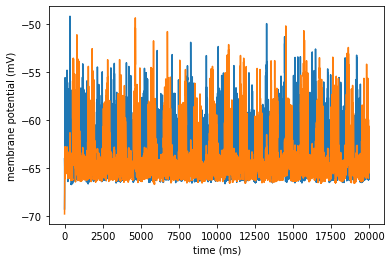

In [344]:
for k in range(2):
    plot(L1_trace.t / ms, L1_trace[k].vm / mV)
print(L1_spikes.count_)

xlabel('time (ms)')
ylabel('membrane potential (mV)')
show()

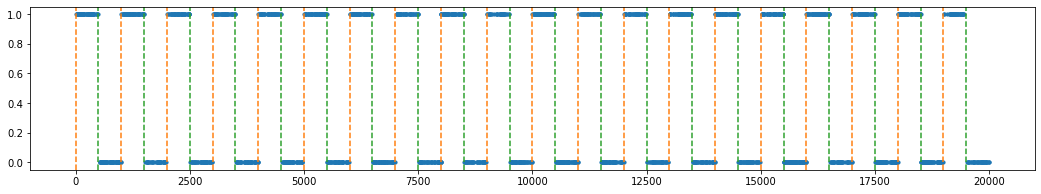

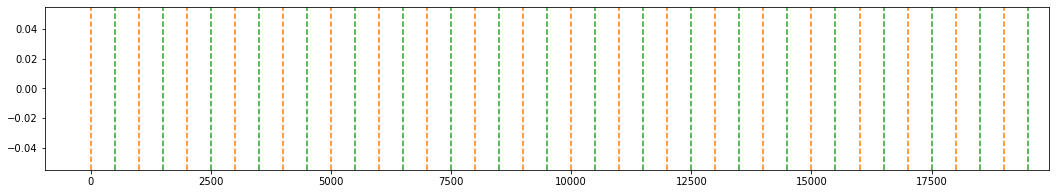

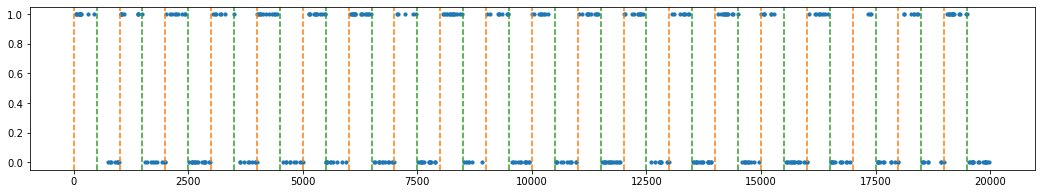

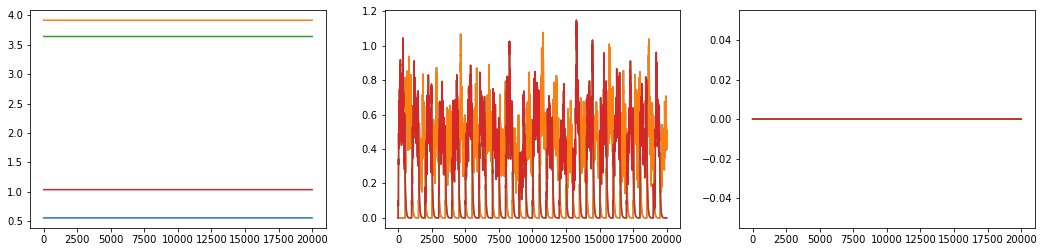

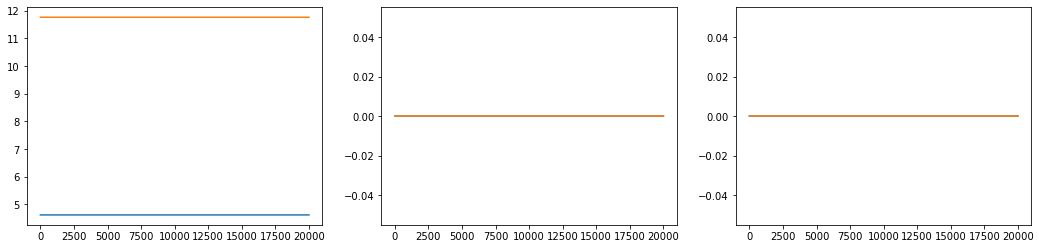

In [345]:
plot_spikes(inPG_spikes)
plot_spikes(L1_spikes)
plot_spikes(tarPG_spikes)
plot_syn_layer(inL_trace, 4)
plot_syn_layer(ihL_trace, 2)

## Simplify models

In [372]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(np.zeros(Ns), np.arange(Ns), 'ok', ms=10)
    plot(np.ones(Nt), np.arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
def plot_spikes(mon):
    figure(figsize=(20,3))
    scatter(mon.t/ms, mon.i, s=8)
    for t in range(0, run_time, 2*change_time):
        axvline(t, ls='--', c='C1')
        axvline(t + change_time, ls='--', c='C2')        
    
    show()

def plot_syn_layer(L, n):
    figure(figsize=(20,4))
    subplot(131)
    for k in range(n):
        plot(L.t/ms, L.w_syn[k])
    subplot(132)
    for k in range(n):
        plot(L.t/ms, L.apre[k])
    subplot(133)
    for k in range(n):
        plot(L.t/ms, L.apost[k])
    show()
    
def plot_vm(L, n):
    figure(figsize=(20, 4))
    for k in range(n):
        plot(L.t / ms, L[k].vm / mV)
    xlabel('time (ms)')
    ylabel('membrane potential (mV)')
    show()

In [358]:
input_patterns = array([[0., 1.], [1., 0.]])
target_patterns = input_patterns
n_patterns = input_patterns.shape[0]
# input_patterns = input_patterns.reshape((n_patterns, -1))

poisson_params = 80, 1.

# stimulus = TimedArray(np.tile([100., 0.], 5)*Hz, dt=100.*ms)
# P = PoissonGroup(1, rates='stimulus(t)')

poisson_rates = input_patterns * np.random.normal(poisson_params[0], poisson_params[1], size=input_patterns.shape)
poisson_rates

array([[ 0.        , 78.53088248],
       [79.20652809,  0.        ]])

In [368]:
start_scope()
seed(1337)

# Parameters
N = 2
taum = 40 * ms
EL = -70.6 * mV
Vcut = VT = -50.4 * mV
Vr = EL - 3 * mV
I_tonic = 0.0 * .6 * mV

eqs = """
dvm/dt = (I + EL - vm)/taum : volt (unless refractory)
I : volt
"""

run_circles = 20
change_time = 200
k = 25
input_indices = tile(repeat([0, 1], k), run_circles)
input_spikes = change_time * linspace(0, 2 * run_circles, 2*k*run_circles, endpoint=False)
inPG = SpikeGeneratorGroup(N, input_indices, input_spikes * ms)

k = 15
input_indices = target_indices = tile(repeat([0, 1], k), run_circles)
input_spikes = target_spikes = change_time * linspace(0, 2 * run_circles, 2*k*run_circles, endpoint=False)
tarPG = SpikeGeneratorGroup(N, target_indices, target_spikes * ms)

L1 = NeuronGroup(
    N, model=eqs, threshold='vm>Vcut',
    reset="vm=Vr",
    refractory='vm>=Vcut',
    method='euler'
)
L1.vm = 'EL + rand()*5*mV'
L1.I = I_tonic

# Dopamine signaling
taupre = taupost = 50*ms
w_syn_max = 15.
Apre = 0.01 * w_syn_max
Apost = -Apre*taupre/taupost*1.05
inL = Synapses(
    inPG, L1, 
    '''
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    w_syn: 1
    ''',    
    on_pre='''
    vm_post += w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0, w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0, w_syn_max)
    ''',
    method='euler'
)
inL.connect(i=[0, 0, 1, 1], j = [0, 1, 0, 1])
inL.w_syn = '.3 * w_syn_max * rand() + .25 * w_syn_max * (1 - j) * i + .25 * w_syn_max * (1 - i) * j'

# tarL = Synapses(
#     tarPG, inL, '',    
#     on_pre='d_post += epsilon_dopa',
#     method='exact'
# )
# tarL.connect(i = [0, 0, 1, 1], j = [0, 1, 2, 3])

# self_inhL = Synapses(
#     L1, inL, '',
#     on_pre='d_post -= epsilon_dopa; w_syn_post -= .1',
#     method='exact',
# )
# self_inhL.connect(i = [0, 0, 1, 1], j = [0, 1, 2, 3])

ihL = Synapses(
    L1, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post -= 0 * w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0, w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
ihL.connect(condition='i!=j')
ihL.w_syn = 'w_syn_max * rand()'

inPG_spikes = SpikeMonitor(inPG)
# tarPG_spikes = SpikeMonitor(tarPG)
L1_trace = StateMonitor(L1, 'vm', record=True)
L1_spikes = SpikeMonitor(L1)
inL_trace = StateMonitor(inL, ['w_syn', 'apre', 'apost'], record=True)
ihL_trace = StateMonitor(ihL, ['w_syn', 'apre', 'apost'], record=True)

# visualise_connectivity(tarL)

run_time, pre_train = 2 * run_circles * change_time, 4 * change_time
run(pre_train * ms)
# inL.mode = 1
run((run_time - pre_train) * ms)

<spikemonitor_7.count_: array([206, 196], dtype=int32)>


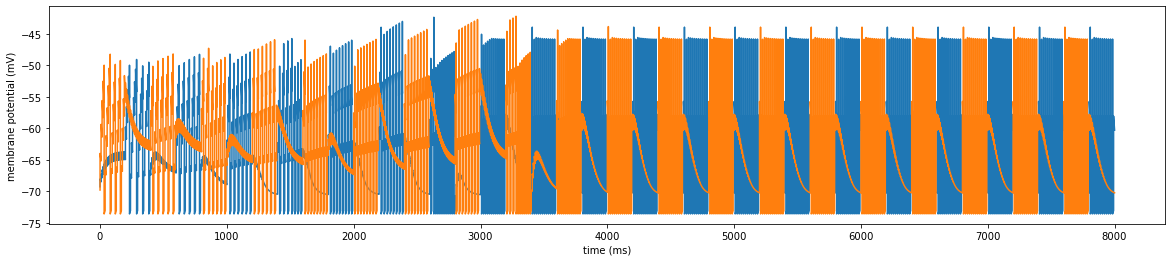

In [373]:
print(L1_spikes.count_)
plot_vm(L1_trace, 2)

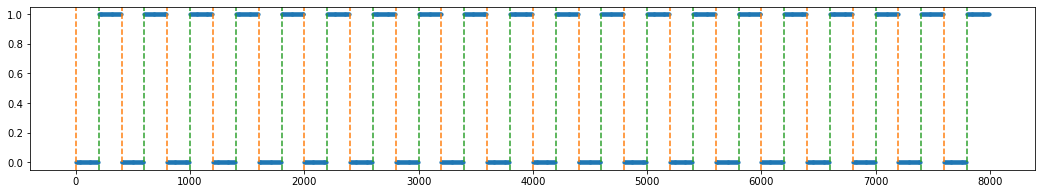

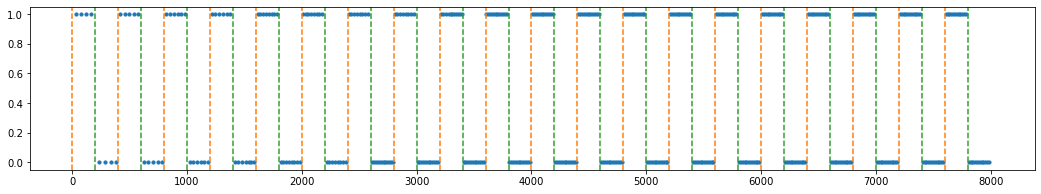

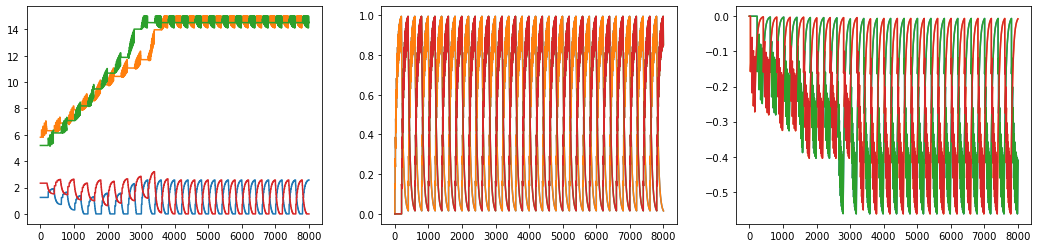

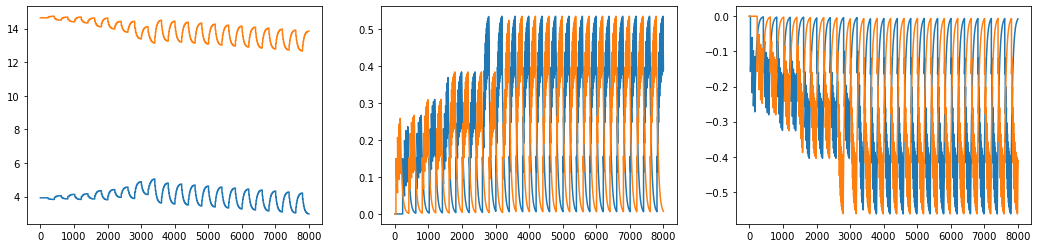

In [370]:
plot_spikes(inPG_spikes)
plot_spikes(L1_spikes)
# plot_spikes(tarPG_spikes)
plot_syn_layer(inL_trace, 4)
plot_syn_layer(ihL_trace, 2)

### Add inhibition

In [430]:
start_scope()
seed(1337)

# Parameters
N = 2
taum = 40 * ms
EL = -70.6 * mV
Vcut = VT = -50.4 * mV
Vr = EL - 3 * mV
I_tonic = 0.5 * .6 * mV

eqs = """
dvm/dt = (I + EL - vm)/taum : volt (unless refractory)
I : volt
"""

run_circles = 5
change_time = 200
k = change_time * 25 // 200
input_indices = tile(repeat([0, 1], k), run_circles)
input_spikes = change_time * linspace(0, 2 * run_circles, 2*k*run_circles, endpoint=False)
inPG = SpikeGeneratorGroup(N, input_indices, input_spikes * ms)

k = change_time * 15 // 200
input_indices = target_indices = tile(repeat([0, 1], k), run_circles)
input_spikes = target_spikes = change_time * linspace(0, 2 * run_circles, 2*k*run_circles, endpoint=False)
tarPG = SpikeGeneratorGroup(N, target_indices, target_spikes * ms)

L1 = NeuronGroup(
    N, model=eqs, threshold='vm>Vcut',
    reset="vm=Vr",
    refractory='vm>=Vcut',
    method='euler'
)
L1.vm = 'EL + rand()*5*mV'
L1.I = I_tonic

# Dopamine signaling
taupre = taupost = 40*ms
w_syn_max = 40.
Apre = 0.01 * w_syn_max
Apost = -Apre*taupre/taupost*1.05
inL = Synapses(
    inPG, L1, 
    '''
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    w_syn: 1
    ''',    
    on_pre='''
    vm_post += w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0, w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0, w_syn_max)
    ''',
    method='euler'
)
inL.connect(i=[0, 0, 1, 1], j = [0, 1, 0, 1])
inL.w_syn = 'w_syn_max * (.1 + .3 * rand() + .2 * (1 - j) * i + .2 * (1 - i) * j)'

# tarL = Synapses(
#     tarPG, inL, '',    
#     on_pre='d_post += epsilon_dopa',
#     method='exact'
# )
# tarL.connect(i = [0, 0, 1, 1], j = [0, 1, 2, 3])

# self_inhL = Synapses(
#     L1, inL, '',
#     on_pre='d_post -= epsilon_dopa; w_syn_post -= .1',
#     method='exact',
# )
# self_inhL.connect(i = [0, 0, 1, 1], j = [0, 1, 2, 3])

ihL = Synapses(
    L1, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre * 4/taupre : 1 (clock-driven)
    dapost/dt = -apost * 4/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post -= 0.5 * w_syn * mV
    apre += Apre * 2
    w_syn = clip(w_syn + apost, 0, w_syn_max)
    ''',
    on_post='''
    apost += Apost * 2
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
ihL.connect(condition='i!=j')
ihL.w_syn = 'w_syn_max * (.3 + .2 * rand())'

inPG_spikes = SpikeMonitor(inPG)
# tarPG_spikes = SpikeMonitor(tarPG)
L1_trace = StateMonitor(L1, 'vm', record=True)
L1_spikes = SpikeMonitor(L1)
inL_trace = StateMonitor(inL, ['w_syn', 'apre', 'apost'], record=True)
ihL_trace = StateMonitor(ihL, ['w_syn', 'apre', 'apost'], record=True)

# visualise_connectivity(tarL)

run_time, pre_train = 2 * run_circles * change_time, 4 * change_time
run(pre_train * ms)
# inL.mode = 1
run((run_time - pre_train) * ms)

<spikemonitor_4.count_: array([109, 112], dtype=int32)>


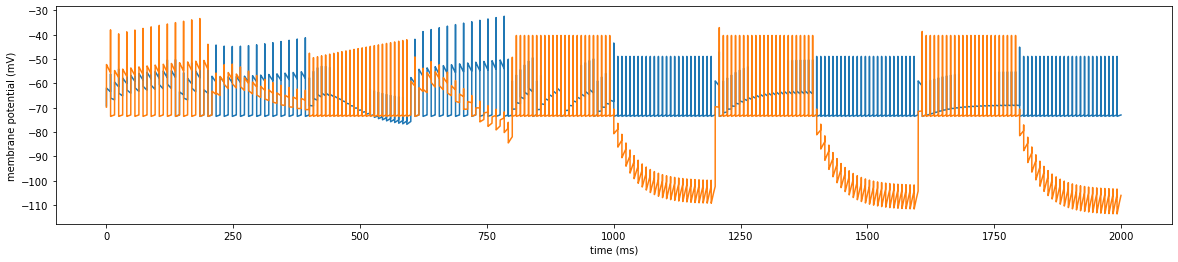

In [431]:
print(L1_spikes.count_)
plot_vm(L1_trace, 2)

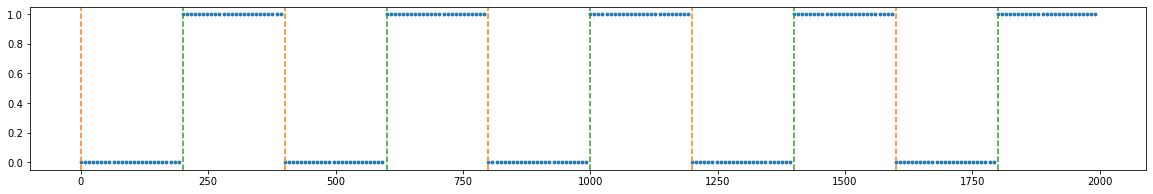

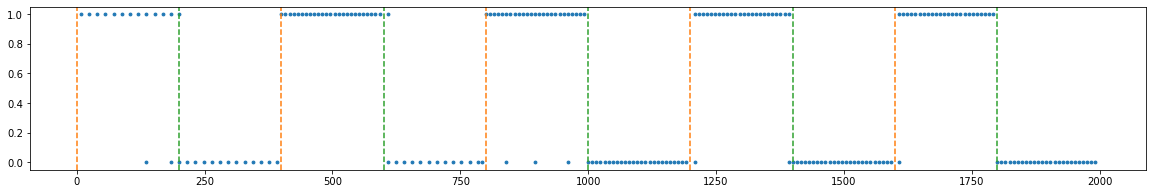

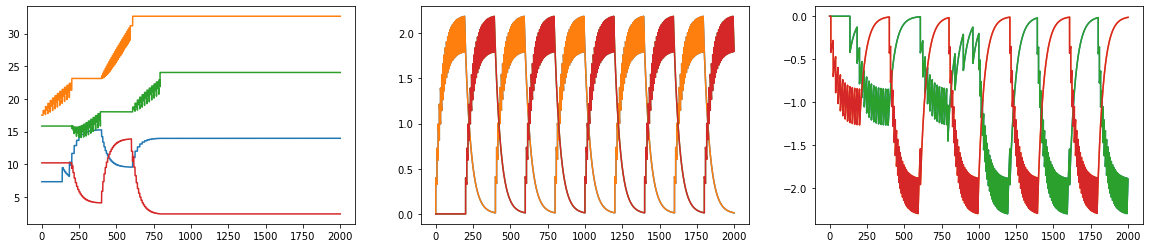

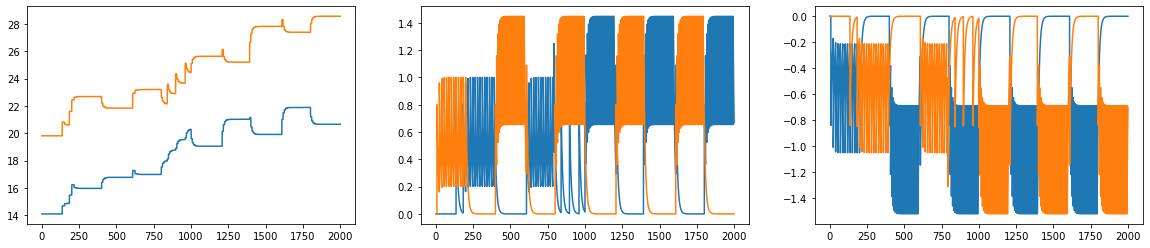

In [432]:
plot_spikes(inPG_spikes)
plot_spikes(L1_spikes)
# plot_spikes(tarPG_spikes)
plot_syn_layer(inL_trace, 4)
plot_syn_layer(ihL_trace, 2)

### Add dopamine-based reinforcement

In [454]:
start_scope()
seed(1337)

# Parameters
N = 2
taum = 40 * ms
EL = -70.6 * mV
Vcut = VT = -50.4 * mV
Vr = EL - 3 * mV
I_tonic = 0.5 * .6 * mV

eqs = """
dvm/dt = (I + EL - vm)/taum : volt (unless refractory)
I : volt
"""

run_circles = 5
change_time = 200
k = change_time * 25 // 200
input_indices = tile(repeat([0, 1], k), run_circles)
input_spikes = change_time * linspace(0, 2 * run_circles, 2*k*run_circles, endpoint=False)
inPG = SpikeGeneratorGroup(N, input_indices, input_spikes * ms)

k = change_time * 15 // 200
input_indices = target_indices = tile(repeat([0, 1], k), run_circles)
input_spikes = target_spikes = change_time * linspace(0, 2 * run_circles, 2*k*run_circles, endpoint=False)
tarPG = SpikeGeneratorGroup(N, target_indices, target_spikes * ms)

L1 = NeuronGroup(
    N, model=eqs, threshold='vm>Vcut',
    reset="vm=Vr",
    refractory='vm>=Vcut',
    method='euler'
)
L1.vm = 'EL + rand()*5*mV'
L1.I = I_tonic

# Dopamine signaling
tauc = 400*ms
taud = 100*ms
taus = 5*ms
taupre = taupost = 40*ms
w_syn_max = 40.
Apre = 0.01 * w_syn_max
Apost = -Apre*taupre/taupost*1.05
inL = Synapses(
    inPG, L1, 
    '''
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    mode: 1
    dc/dt = -c / tauc : 1 (clock-driven)
    dd/dt = -d / taud : 1 (clock-driven)
    dw_syn/dt = mode * c * d / taus : 1 (clock-driven)
    ''',
    on_pre='''
    vm_post += w_syn * mV
    apre += Apre
    c = clip(c + mode * apost, 0, w_syn_max)
    w_syn = clip(w_syn + (1 - mode) * apost, 0, w_syn_max)
    ''',
    on_post='''
    apost += Apost
    c = clip(c + mode * apre, 0, w_syn_max)
    w_syn = clip(w_syn + (1 - mode) * apre, 0, w_syn_max)
    ''',
    method='euler'
)
inL.connect(i=[0, 0, 1, 1], j = [0, 1, 0, 1])
inL.mode = 0
inL.c = 1e-9
inL.d = 0
inL.w_syn = 'w_syn_max * (.1 + .3 * rand() + .2 * (1 - j) * i + .2 * (1 - i) * j)'

epsilon_dopa = .001
tarL = Synapses(
    tarPG, inL, '',    
    on_pre='d_post += epsilon_dopa',
    method='exact'
)
tarL.connect(i = [0, 0, 1, 1], j = [0, 1, 2, 3])

self_inhL = Synapses(
    L1, inL, '',
    on_pre='''
    d_post -= epsilon_dopa
    vm_post_post = w_syn_post * mV
    w_syn_post -= .0
    ''',
    method='exact',
)
self_inhL.connect(i = [0, 0, 1, 1], j = [0, 1, 2, 3])

ihL = Synapses(
    L1, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre * 4/taupre : 1 (clock-driven)
    dapost/dt = -apost * 4/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post -= 0.5 * w_syn * mV
    apre += Apre * 2
    w_syn = clip(w_syn + apost, 0, w_syn_max)
    ''',
    on_post='''
    apost += Apost * 2
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
ihL.connect(condition='i!=j')
ihL.w_syn = 'w_syn_max * (.3 + .2 * rand())'

inPG_spikes = SpikeMonitor(inPG)
tarPG_spikes = SpikeMonitor(tarPG)
L1_trace = StateMonitor(L1, 'vm', record=True)
L1_spikes = SpikeMonitor(L1)
inL_trace = StateMonitor(inL, ['w_syn', 'apre', 'apost'], record=True)
ihL_trace = StateMonitor(ihL, ['w_syn', 'apre', 'apost'], record=True)

# visualise_connectivity(tarL)

run_time, pre_train = 2 * run_circles * change_time, 4 * change_time
run(pre_train * ms)
inL.mode = 1
run((run_time - pre_train) * ms)

<spikemonitor_9.count_: array([ 95, 111], dtype=int32)>


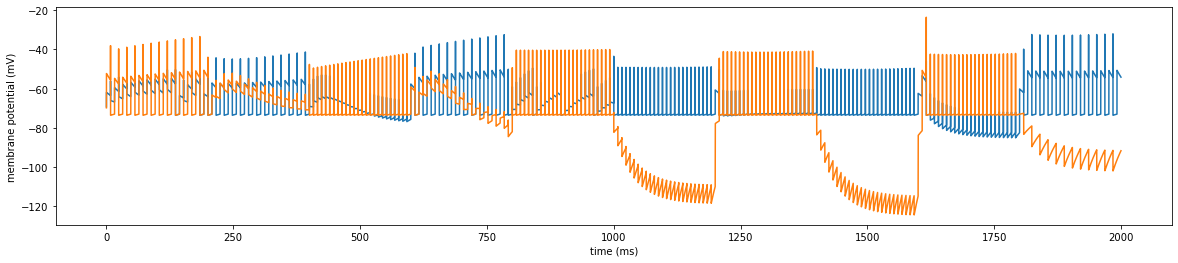

In [455]:
print(L1_spikes.count_)
plot_vm(L1_trace, 2)

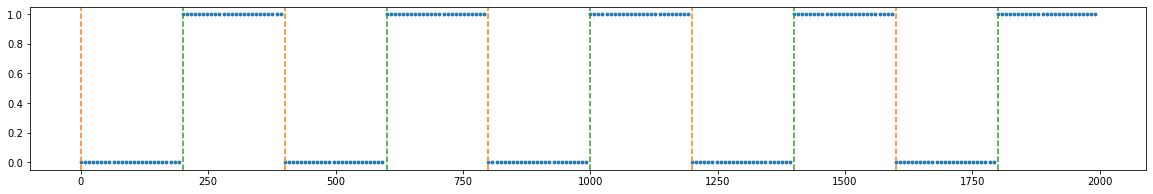

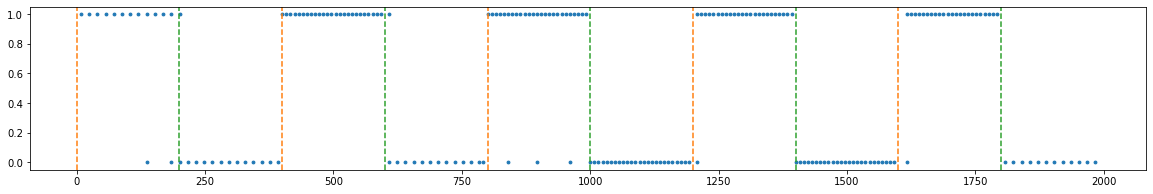

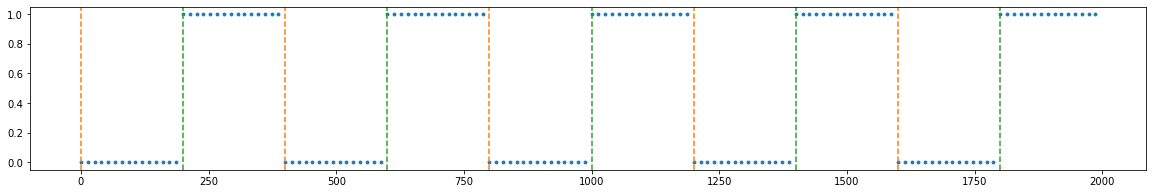

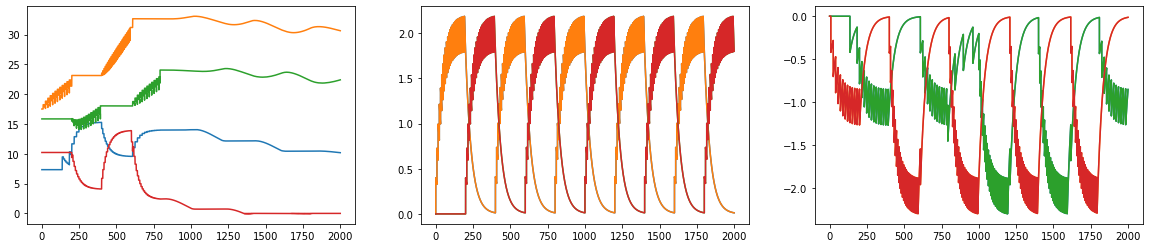

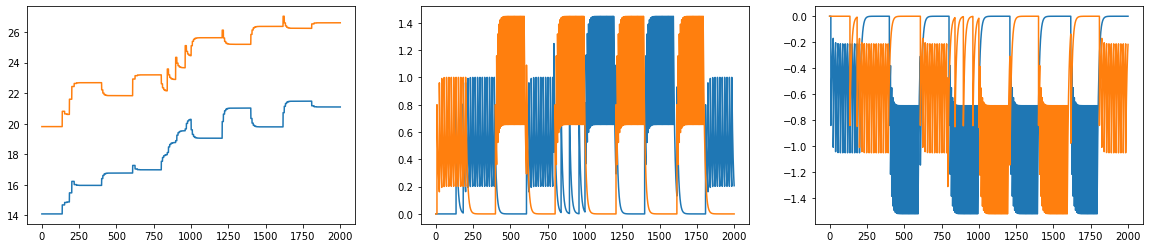

In [456]:
plot_spikes(inPG_spikes)
plot_spikes(L1_spikes)
plot_spikes(tarPG_spikes)
plot_syn_layer(inL_trace, 4)
plot_syn_layer(ihL_trace, 2)